In [3]:
import cv2
import os
import numpy as np
import pickle

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # GPU 사용 비활성화

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 증가 허용
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
sequence_length = 30
overlap = 15 
video_top_folder = "D:/dataset_5"
pickle_folder = "D:\pickle_data_6"

In [3]:


def frame_generator(video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_width = 128
        img_height = 128
        frame_resized = cv2.resize(gray_frame, (img_width, img_height))
        frame_array = np.array(frame_resized) / 255.0
        yield frame_array
    cap.release()

def process_video(video_path, sequence_length, overlap, pickle_folder):
    frame_count = 0
    sequences = []
    frame_gen = frame_generator(video_path)

    while True:
        try:
            frame_array = next(frame_gen)
        except StopIteration:
            break

        if frame_count % (sequence_length - overlap) == 0:
            sequences.append([])

        sequences[-1].append(frame_array)
        frame_count += 1

    for seq_index in range(len(sequences)):
        sequence = sequences[seq_index]
        padding_needed = sequence_length - len(sequence)
        if padding_needed > 0:
            padding_frames = [np.zeros_like(frame_array) for _ in range(padding_needed)]
            sequences[seq_index].extend(padding_frames)

    label = os.path.splitext(os.path.basename(video_path))[0].split('_')[0]
    pickle_filename = os.path.join(pickle_folder, f'{label}.pkl')

    if os.path.exists(pickle_filename):
        with open(pickle_filename, 'rb') as f:
            existing_sequences = pickle.load(f)
            sequences = existing_sequences + sequences

    with open(pickle_filename, 'wb') as f:
        pickle.dump(sequences, f)

def process_folder(folder_path, sequence_length, overlap, pickle_folder):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            video_path = os.path.join(root, file)
            process_video(video_path, sequence_length, overlap, pickle_folder)


In [4]:
process_folder(video_top_folder, sequence_length, overlap, pickle_folder)

In [5]:
import os
import pickle
from collections import defaultdict

data_directory = "D:/pickle_data_5"

# 각 행동별 mp4 파일 수, 시퀀스 수, 프레임 수를 저장할 딕셔너리
action_stats = defaultdict(lambda: {'sequences': 0, 'frame_count': 0})

for filename in os.listdir(data_directory):
    if filename.endswith(".pkl"):
        action = filename.split('_')[0]  # 파일명에서 행동 추출

        with open(os.path.join(data_directory, filename), 'rb') as f:
            sequences = pickle.load(f)
            action_stats[action]['sequences'] += len(sequences)
            action_stats[action]['frame_count'] += sum(len(seq) for seq in sequences)
            #action_stats[action]['mp4_count'] += 1

# 결과 출력
for action, info in action_stats.items():
    print(f"{action}: {info['sequences']} sequences, {info['frame_count']} frames")

broken.pkl: 364 sequences, 10920 frames
buying.pkl: 362 sequences, 10860 frames
compare.pkl: 362 sequences, 10860 frames
fight.pkl: 366 sequences, 10980 frames
moving.pkl: 366 sequences, 10980 frames
return.pkl: 363 sequences, 10890 frames
select.pkl: 362 sequences, 10860 frames
test.pkl: 361 sequences, 10830 frames
theft.pkl: 367 sequences, 11010 frames


In [6]:
#import random

# 데이터 구성을 위한 리스트 초기화
X_sequences = []  # 시퀀스 데이터
y_labels = []     # 시퀀스에 대한 레이블

# 모든 피클 파일에 대해 반복
for filename in os.listdir(data_directory):
    if filename.endswith(".pkl"):
        action = filename.split('.')[0]  # 파일명에서 '.pkl' 확장자 제거하여 행동 추출

        with open(os.path.join(data_directory, filename), 'rb') as f:
            sequences = pickle.load(f)
            
            # 각 시퀀스를 X_sequences에 추가하고 해당 행동을 y_labels에 추가
            for sequence in sequences:
                X_sequences.append(sequence)
                y_labels.append(action)

In [ ]:
# LSTM

In [7]:
X_sequences_array=np.array(X_sequences)

In [10]:
# X_sequences_array를 3D 형태로 변환. 데이터 타입 변경
X_sequences_reshaped = X_sequences_array.reshape(X_sequences_array.shape[0], X_sequences_array.shape[1], -1).astype('float32')

In [11]:
X_sequences_reshaped.shape

(3273, 30, 16384)

In [12]:
y_labels_array = np.array(y_labels)

In [13]:
y_labels_array.shape

(3273,)

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 레이블을 숫자로 변환
label_encoder = LabelEncoder()
y_labels_numerical = label_encoder.fit_transform(y_labels)

# 숫자와 레이블 간의 매핑 저장
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

# 숫자를 원핫인코딩
onehot_encoder = OneHotEncoder(sparse=False)
y_labels_onehot = onehot_encoder.fit_transform(y_labels_numerical.reshape(-1, 1))

C:\Users\user\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
label_mapping

{0: 'broken',
 1: 'buying',
 2: 'compare',
 3: 'fight',
 4: 'moving',
 5: 'return',
 6: 'select',
 7: 'test',
 8: 'theft'}

In [16]:
from sklearn.model_selection import train_test_split

# 전체 데이터를 훈련용과 검증용으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X_sequences_reshaped, y_labels_onehot, test_size=0.2, random_state=42)

In [17]:
def validation_sequence_generator(X_sequences, y_labels, batch_size=32):
    num_samples = X_sequences.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    while True:
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            
            batch_X = X_sequences[batch_indices]
            batch_y = y_labels[batch_indices]
            
            yield batch_X, batch_y

In [18]:
# 제너레이터 생성
new_batch_size = 32
new_validation_sequence_generator = validation_sequence_generator(X_val, y_val, batch_size=new_batch_size)

In [19]:
new_train_sequence_generator = validation_sequence_generator(X_train, y_train, batch_size=new_batch_size)

In [20]:
# LSTM 모델 생성
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

num_classes = 9

model = Sequential()
model.add(LSTM(units=128, input_shape=(X_sequences_reshaped.shape[1], X_sequences_reshaped.shape[2]), return_sequences=True))
model.add(LSTM(64, dropout=0.3, return_sequences=True))
model.add(LSTM(64, dropout=0.3, return_sequences=True))
model.add(LSTM(32, dropout=0.3, return_sequences=True))
model.add(LSTM(16, dropout=0.3))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# Early Stopping, Model Checkpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=8)
model_checkpoint = ModelCheckpoint('LSTM_4.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.00001)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           8454656   
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 30, 32)            12416     
                                                                 
 lstm_4 (LSTM)               (None, 16)                3136      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 9)                 1

In [21]:
history = model.fit(
    new_train_sequence_generator,  
    steps_per_epoch=len(X_train) // new_batch_size,  # 한 에폭당 단계 수
    epochs=30,
    callbacks=[early_stopping, model_checkpoint],
    validation_data=new_validation_sequence_generator,  # 검증 데이터셋 제너레이터
    validation_steps=len(X_val) // new_batch_size  # 검증 단계 수
)

Epoch 1/30
81/81 [==============================] - 60s 610ms/step - loss: 2.1476 - accuracy: 0.2083 - val_loss: 2.0335 - val_accuracy: 0.2531
Epoch 2/30


C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 46s 570ms/step - loss: 1.8275 - accuracy: 0.4578 - val_loss: 1.5708 - val_accuracy: 0.5987
Epoch 3/30
81/81 [==============================] - 45s 556ms/step - loss: 1.4341 - accuracy: 0.6833 - val_loss: 1.2390 - val_accuracy: 0.7785
Epoch 4/30
81/81 [==============================] - 45s 554ms/step - loss: 1.1453 - accuracy: 0.7746 - val_loss: 1.1243 - val_accuracy: 0.7833
Epoch 5/30
81/81 [==============================] - 45s 559ms/step - loss: 0.9448 - accuracy: 0.7997 - val_loss: 0.7355 - val_accuracy: 0.8523
Epoch 6/30
81/81 [==============================] - 45s 552ms/step - loss: 0.7738 - accuracy: 0.8206 - val_loss: 0.7826 - val_accuracy: 0.7608
Epoch 7/30
81/81 [==============================] - 45s 555ms/step - loss: 0.6800 - accuracy: 0.8306 - val_loss: 0.5696 - val_accuracy: 0.8539
Epoch 8/30
81/81 [==============================] - 46s 564ms/step - loss: 0.6166 - accuracy: 0.8341 - val_loss: 0.5090 - val_accuracy: 0.8828
Epoch 9/30

In [22]:
# 모델 평가
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Test accuracy: {accuracy}')

21/21 [==============================] - 3s 161ms/step - loss: 0.2109 - accuracy: 0.9649
Test accuracy: 0.9648854732513428


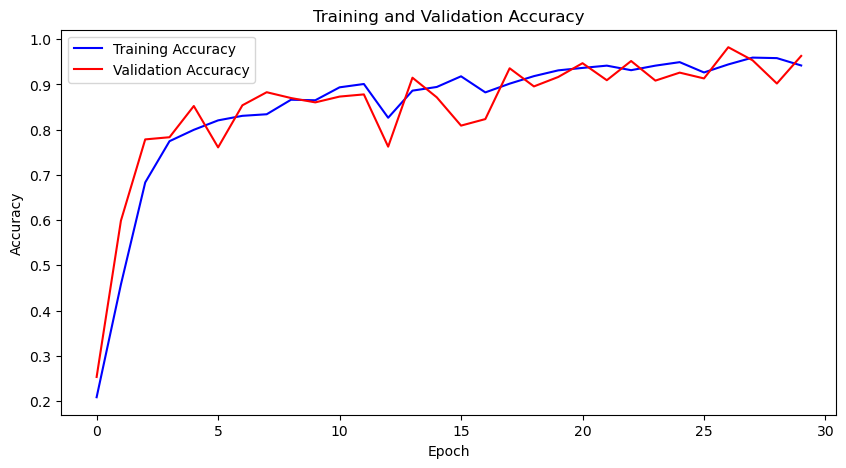

In [23]:
import matplotlib.pyplot as plt

# 훈련 및 검증 데이터의 정확도 값 저장
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 훈련 및 검증 데이터의 손실 값 저장
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 정확도 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

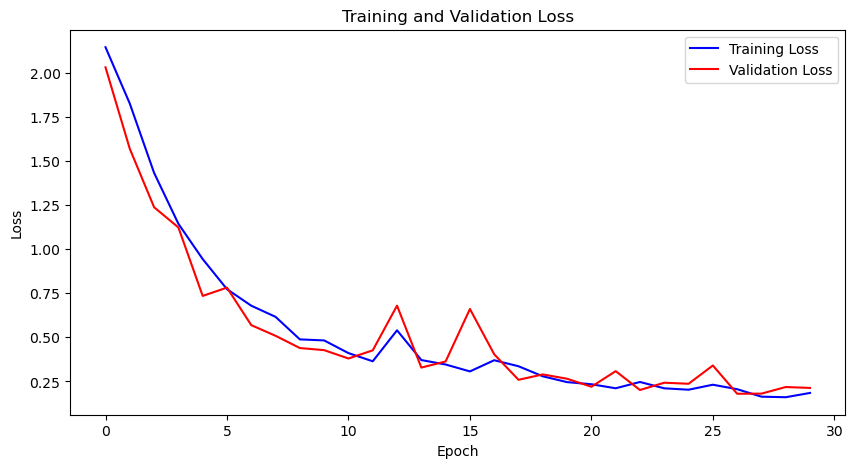

In [24]:
# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 정상, 비정상으로 분류
# 분류 결과가 시퀀스 별로 다 나온다

In [29]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# 테스트 영상 파일 경로
test_video_path = "C:/Users/user/Downloads/IMG_9468.mp4"

# 모델 불러오기
model_path = "C:/Users/user/Desktop/Final project/LSTM_4.h5"
model = load_model(model_path)

# 라벨 이름 매핑
class_names = {0: 'abnormal', 1: 'normal', 2: 'normal', 3: 'abnormal', 4: 'normal', 5: 'normal', 6: 'normal', 7: 'normal', 8: 'abnormal'}

# VideoCapture를 사용하여 테스트 영상 열기
cap = cv2.VideoCapture(test_video_path)

# VideoCapture를 사용하여 테스트 영상의 속성 가져오기
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# VideoWriter 객체 생성
output_path = 'test_2.mp4'  # 결과를 저장할 파일 경로
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))


In [30]:

frame_buffer = []  # 프레임을 저장할 버퍼
predictions_buffer = []  # 결과를 저장할 버퍼

while True:
    ret, frame = cap.read()
    if not ret:
        break

    resized_frame = cv2.resize(frame, (128, 128))
    gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    normalized_frame = gray_frame / 255.0
    frame_buffer.append(normalized_frame.flatten())  # 특징 추출 후 버퍼에 저장

    if len(frame_buffer) == 30:  # 30프레임씩 모아서 처리
        input_data = np.array(frame_buffer)  # 30프레임을 NumPy 배열로 변환
        input_data = input_data.reshape(1, 30, -1)  # 모델에 입력하기 위해 형태 변환
        predictions = model.predict(input_data)  # 모델로 예측 수행

        # abnormal과 normal로 결과 재매핑
        predicted_classes = [class_names[np.argmax(prediction)] for prediction in predictions]
        mapped_predictions = []
        for predicted_class in predicted_classes:
            if predicted_class in ['abnormal', 'normal']:
                mapped_predictions.append(predicted_class)
            else:
                mapped_predictions.append('normal')  # 나머지 클래스는 normal로 매핑
        
        predictions_buffer.extend(mapped_predictions)  # 결과 저장
        frame_buffer = []  # 버퍼 비우기

    # 텍스트 추가
    if predictions_buffer:
        text = f"Action: {', '.join(predictions_buffer)}"
        cv2.putText(frame, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # 오버레이된 프레임을 저장
    out.write(frame)

# 작업 완료 후 해제
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 62ms/step
